In [ ]:
# !pip install imutils
# !pip install pdfplumber
# !pip install pdfminer.six

In [1]:
import pandas as pd
import pdfplumber

# pdf 파일 불러오기
pdf = pdfplumber.open("./dataset/11.pdf")
# 전체 페이지 중 1개 페이지 대상
page = pdf.pages[0]

# 한 페이지 중 1개 테이블 대상
tables = page.extract_tables()
table = tables[0]

# 테이블 데이터프레임으로 변환
df = pd.DataFrame(table[1:], columns=table[0])
df

,no,model,id,description,license
0,1,haiteam,a,d,
1,2,kaiteam,b,e,
2,3,test,c,f,
3,4,,,,


# 2. OCR활용 테이블 값추출 (키워드 기반)

In [3]:
import imutils
import cv2
from pdf2image import convert_from_path
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

import re

from imutils.perspective import four_point_transform

import pytesseract

# OCR 설치 -> # 설치필요: https://github.com/UB-Mannheim/tesseract/wiki
# 설정파일 실행 (설치위치 포인트 잡기)
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# 1. 파일 불러오기

In [28]:
# 파일 경로 설정
dataPath = "dataset"
filePath = '1.pdf'  # 또는 '1.jpg' 1.png, 1.jpeg, 1.pdf
fileFullPath = os.path.join(dataPath,filePath)

In [29]:
def load_images(file_path, dpi=500, poppler_path=None):
    ext = os.path.splitext(file_path)[1].lower()  # 파일 확장자 확인
    images = []
    
    if ext == '.pdf':
        # PDF 파일을 이미지로 변환
        images = convert_from_path(file_path, dpi, poppler_path=poppler_path)
    elif ext in ['.jpg', '.jpeg', '.png']:
        # JPG, JPEG, PNG 파일을 로드
        image = Image.open(file_path)
        images.append(image)
    else:
        raise ValueError("지원하지 않는 파일 형식입니다. PDF, JPG, JPEG, PNG 파일만 지원합니다.")
    
    return images

# 이미지 로드
pages = load_images(fileFullPath, dpi=500, poppler_path=r'D:\poppler-24.02.0\Library\bin')

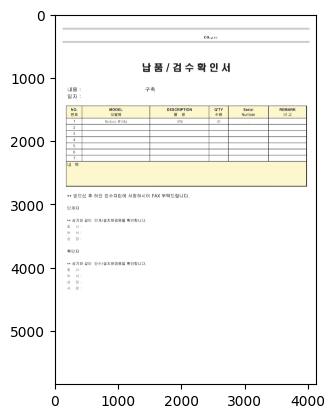

In [30]:
eachImg = np.array( pages[0] )

plt.imshow(eachImg)

# 2. 이미지 전처리

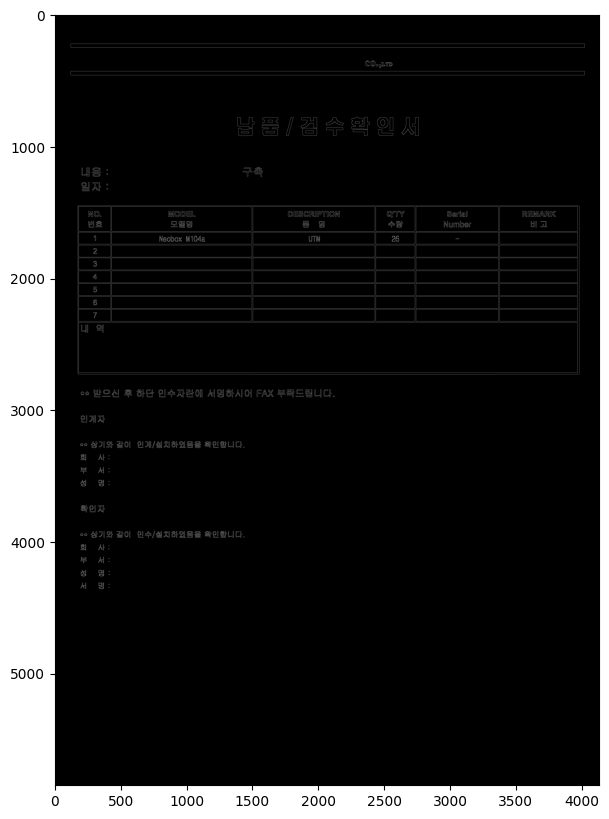

In [31]:
image = eachImg.copy()
# image = imutils.resize(image, width=500)

### 색상제거
try:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
except Exception as e:
    gray = image.copy()
### 잡음제거
blurred = cv2.GaussianBlur(gray, (5, 5,), 0)
# 윤곽선 처리 (임계값 조정)
lower_thresh = 50  # 하위 임계값
upper_thresh = 150  # 상위 임계값
edged = cv2.Canny(blurred, lower_thresh, upper_thresh)

# 컬러 이미지를 RGB로 변환하여 표시
# rgbImage = cv2.cvtColor(edged, cv2.COLOR_BGR2RGB)
# plt.imshow(gray)
# plt.imshow(blurred)
plt.figure(figsize=(10, 10))
plt.imshow(edged,cmap="gray")

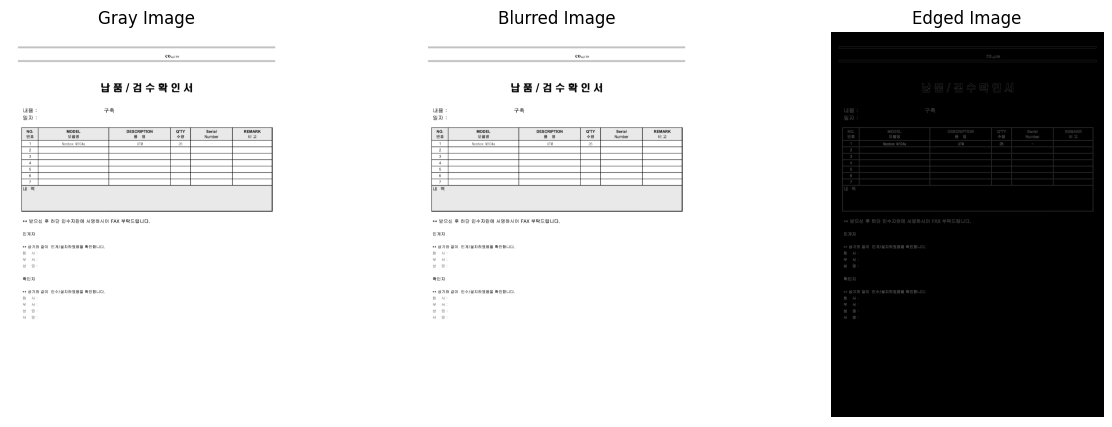

In [32]:
# 결과 이미지 표시
plt.figure(figsize=(15, 5))

# 회색조 이미지
plt.subplot(1, 3, 1)
plt.title('Gray Image')
plt.imshow(gray, cmap='gray')
plt.axis('off')

# 블러 처리된 이미지
plt.subplot(1, 3, 2)
plt.title('Blurred Image')
plt.imshow(blurred, cmap='gray')
plt.axis('off')

# 윤곽선 이미지
plt.subplot(1, 3, 3)
plt.title('Edged Image')
plt.imshow(edged, cmap='gray')
plt.axis('off')

plt.show()

# 3.이미지에서 표만 추출

In [33]:
# 이진화
_, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

# 수평선과 수직선 검출
kernel_h = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
kernel_v = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40))

detect_horizontal = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_h)
detect_vertical = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_v)

# 수평선과 수직선 결합
mask = detect_horizontal + detect_vertical

# 테이블 영역 검출
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 테이블 영역 추출
table_cnt = None
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w > 100 and h > 20:  # 테이블 크기에 따라 조정
        table_cnt = cnt
        break

if table_cnt is not None:
    x, y, w, h = cv2.boundingRect(table_cnt)
    table_roi = image[y:y+h, x:x+w]
else:
    raise Exception("Could not find table outline")

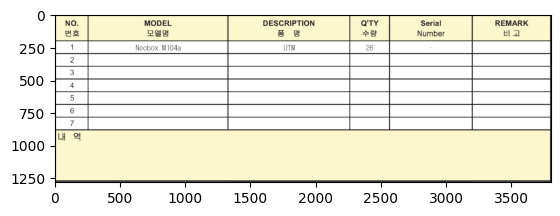

In [34]:
plt.imshow( table_roi, cmap="gray")

# 4. 표에서 키워드에 해당하는 모델코드만 추출

In [35]:
# 이미지에서 텍스트 추출
def extract_text_from_image(table_roi):
    table_text = pytesseract.image_to_string(table_roi, lang='eng')  # 영어로 설정하거나 다른 언어로 설정할 수 있음
    extracted_text = table_text.split('\n')  # 라인별로 처리
    return extracted_text

# 특정 키워드가 포함된 라인 추출
def extract_keywords_containing(lines, keywords_to_find):
    keywords = []
    for line in lines:
        for keyword in keywords_to_find:
            if keyword.lower() in line.lower():  # 대소문자 구분 없이 특정 키워드가 포함되어 있는지 검색
                keywords.append(line)
                break  # 이미 찾은 경우 다음 키워드 검색으로 넘어감
    return keywords

# 특정 모델로 시작하는 키워드 찾기 예시
keyword_starts_with_list = ['GATE', 'Neobox','VForce']  # 원하는 여러 개의 시작 단어를 리스트로 지정

extracted_text = extract_text_from_image(table_roi)

# 추출된 텍스트에서 특정 모델로 시작하는 키워드 추출
keywords = extract_keywords_containing(extracted_text, keyword_starts_with_list)

# 결과 출력
print("Extracted keywords starting with the specified words:")
print(keywords)

Extracted keywords starting with the specified words:
['Neobox M104a']
